In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import os

from impute_missing_values import impute_missing_values
from pickle import dump

## Import data

In [2]:
data = pd.read_csv('data/train.csv')
target = data.Transported
variables = data.drop('Transported', axis=1)
print('Data Shape:', data.shape)
print('Target Shape:', target.shape)
print('Variables Shape:', variables.shape)
variables.head()

Data Shape: (8693, 14)
Target Shape: (8693,)
Variables Shape: (8693, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines


## Fill NAs relating CryoSleep with Bill columns

Every passenger in CryoSleep must have 0 in every billing column.
Using this, we can fill na's of billing columns to 0 when a passenger is in CryoSleep.

In [3]:
bill_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'VRDeck', 'Spa']

filt_cryo = variables.CryoSleep == True
variables[filt_cryo][bill_columns] = variables[filt_cryo][bill_columns].fillna(0)

C:\Users\jfcaliz\AppData\Local\Temp\ipykernel_2164\3547994724.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variables[filt_cryo][bill_columns] = variables[filt_cryo][bill_columns].fillna(0)


In [4]:
variables[filt_cryo].isna().sum()

PassengerId      0
HomePlanet      75
CryoSleep        0
Cabin           84
Destination     48
Age             82
VIP             75
RoomService     68
FoodCourt       70
ShoppingMall    96
Spa             65
VRDeck          62
Name            62
dtype: int64

On the other hand, if a passenger has non zero on some billing and NA in CryoSleep, we can assume that CryoSleep is False.

In [5]:
variables['TotalSpent'] = variables[bill_columns].sum(axis=1)

filt_spent_zero = variables.TotalSpent != 0
variables[filt_spent_zero]['CryoSleep'] = variables[filt_spent_zero]['CryoSleep'].fillna(False)

C:\Users\jfcaliz\AppData\Local\Temp\ipykernel_2164\4076330862.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variables[filt_spent_zero]['CryoSleep'] = variables[filt_spent_zero]['CryoSleep'].fillna(False)


In [6]:
variables[filt_spent_zero].isna().sum()

PassengerId       0
HomePlanet      113
CryoSleep       119
Cabin           102
Destination     119
Age              90
VIP             110
RoomService     103
FoodCourt       102
ShoppingMall    100
Spa             112
VRDeck          102
Name            114
TotalSpent        0
dtype: int64

In [7]:
variables.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
TotalSpent      float64
dtype: object

## Subdivide in columns

Certain columns contain information that can be subdivided into different values.
- Cabin: The value is composed by **deck/num/side**, where some of these have a reduced number of unique values.
- PassengerId: The value is composed by **gggg_pp**, where **gggg** indicates a group and **pp** indicates the passenger's number within the group.
- Name: Can be divided into **Name** and **Surname**.

In [8]:
variables[['Cabin_deck', 'Cabin_num', 'Cabin_side']] = variables.Cabin.str.split('/', expand=True)
variables[['PassengerId_group', 'PassengerId_num']] = variables.PassengerId.str.split('_', expand=True)
variables[['Name', 'Surname']] = variables.Name.str.split(' ', expand=True)

variables.drop(['Cabin', 'PassengerId'], axis=1, inplace=True)

variables.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,TotalSpent,Cabin_deck,Cabin_num,Cabin_side,PassengerId_group,PassengerId_num,Surname
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham,0.0,B,0,P,0001,01,Ofracculy
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna,736.0,F,0,S,0002,01,Vines
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark,10383.0,A,0,S,0003,01,Susent
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam,5176.0,A,0,S,0003,02,Susent
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy,1091.0,F,1,S,0004,01,Santantines


## Transform the types of variables

In [9]:
for col in variables.columns:
    try:
        variables[col] = variables[col].astype('float64')
    except ValueError:
        continue

In [10]:
bool_vars = [col for col in variables.columns if
             variables[col].isin([True, False, np.nan]).all()
             or variables[col].isin([True, False]).all()]
bool_vars

['CryoSleep', 'VIP']

In [11]:
for variable in bool_vars:
    variables.loc[variables[variable] == True, variable] = 1
    variables.loc[variables[variable] == False, variable] = 0

In [12]:
numeric = [col for col in variables.columns if variables[col].dtype == 'float64']
numeric

['CryoSleep',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'TotalSpent',
 'Cabin_num',
 'PassengerId_group',
 'PassengerId_num']

In [13]:
categorical = [col for col in variables.columns if variables[col].dtype == 'object']
categorical = set(categorical).difference(set(bool_vars))
categorical = list(categorical)
categorical

['HomePlanet', 'Name', 'Surname', 'Cabin_side', 'Cabin_deck', 'Destination']

## Inspect missing values

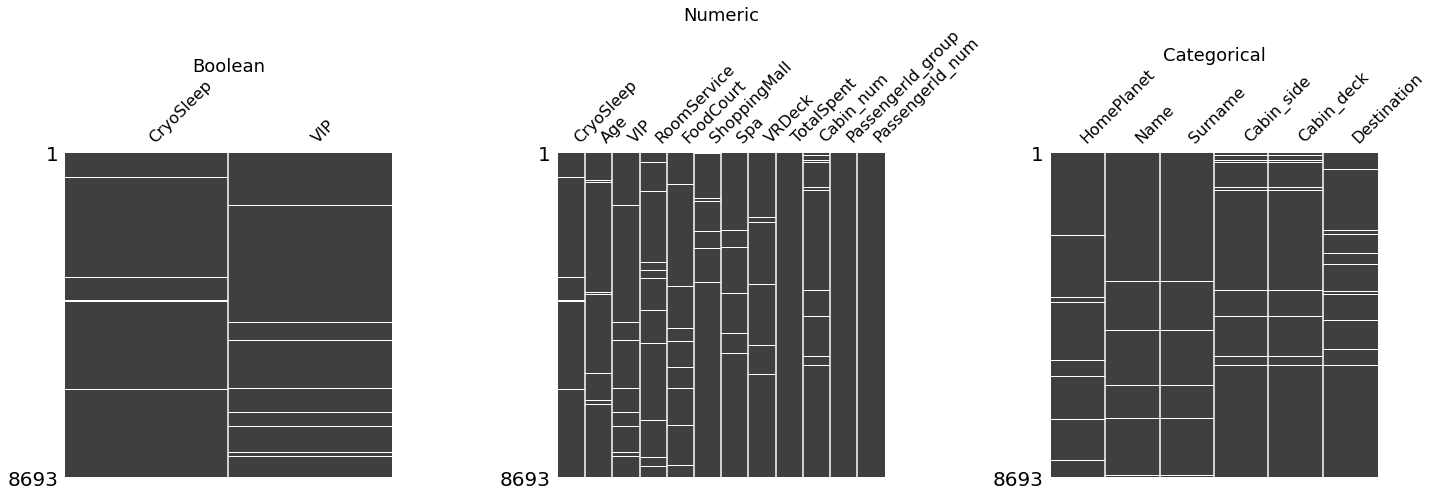

In [14]:
vars_dict = {'Boolean': bool_vars,
             'Numeric': numeric,
             'Categorical': categorical}

fig, axes = plt.subplots(ncols=3, figsize=(20, 7))

for ax, var_type in zip(axes, vars_dict.keys()):
    msno.matrix(variables[vars_dict[var_type]], ax=ax, sparkline=False)
    ax.set_title(var_type, fontsize=18)

plt.tight_layout()
plt.show()

## Inspect categorical variables
Look for amount of unique values

In [15]:
for var in categorical:
    print(f'{var}: {len(variables[var].unique())}')

HomePlanet: 4
Name: 2707
Surname: 2218
Cabin_side: 3
Cabin_deck: 9
Destination: 4


In [16]:
dummy_thresh = 10

var_to_dummy = [variable for variable in categorical if len(variables[variable].unique()) < dummy_thresh]
var_not_to_dummy = [variable for variable in categorical if len(variables[variable].unique()) >= dummy_thresh]
var_to_dummy

['HomePlanet', 'Cabin_side', 'Cabin_deck', 'Destination']

## Fill categorical NAs with **blank**

In [17]:
variables[categorical] = variables[categorical].fillna('blank').copy()
variables[categorical].isna().sum()

HomePlanet     0
Name           0
Surname        0
Cabin_side     0
Cabin_deck     0
Destination    0
dtype: int64

## Create dummy variables
For the ones that have a reduced number of categories

In [18]:
dummy_vars = pd.get_dummies(variables[var_to_dummy])
dummy_vars.head()

,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_blank,Cabin_side_P,Cabin_side_S,Cabin_side_blank,Cabin_deck_A,Cabin_deck_B,Cabin_deck_C,Cabin_deck_D,Cabin_deck_E,Cabin_deck_F,Cabin_deck_G,Cabin_deck_T,Cabin_deck_blank,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Destination_blank
0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [19]:
dummified_variables = pd.concat([variables, dummy_vars], axis=1).drop(var_to_dummy, axis=1)
dummified_variables.drop(var_not_to_dummy, axis=1, inplace=True)
dummified_variables.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalSpent,Cabin_num,...,Cabin_deck_D,Cabin_deck_E,Cabin_deck_F,Cabin_deck_G,Cabin_deck_T,Cabin_deck_blank,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Destination_blank
0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,736.0,0.0,...,0,0,1,0,0,0,0,0,1,0
2,0.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,10383.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,0.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,5176.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,0.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1091.0,1.0,...,0,0,1,0,0,0,0,0,1,0


In [20]:
floor_ceil_dict = {
    'Age': [0, 120],
    'RoomService': [0, np.inf],
    'FoodCourt': [0, np.inf],
    'Spa': [0, np.inf],
    'VRDeck': [0, np.inf],
    'ShoppingMall': [0, np.inf],
    'Cabin_num': [0, np.inf],
    'VIP': [0, 1],
    'CryoSleep': [0, 1]
}

In [21]:
actual_impute, act_problems, act_scores, act_regressors = \
    impute_missing_values(dummified_variables, scores=True, col_floor_ceiling_dict=floor_ceil_dict)

  0%|          | 0/9 [00:00<?, ?it/s]C:\Users\jfcaliz\Anaconda3\envs\SpaceshipTitanic\lib\site-packages\impute_missing_values.py:51: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  int_df = pd.get_dummies(df_.loc[:, both_cols], drop_first=False)
C:\Users\jfcaliz\Anaconda3\envs\SpaceshipTitanic\lib\site-packages\impute_missing_values.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_[col][na_index] = preds
 11%|█         | 1/9 [00:00<00:01,  7.52it/s]C:\Users\jfcaliz\Anaconda3\envs\SpaceshipTitanic\lib\site-packages\impute_missing_values.py:51: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  int_df = pd.get_dummies(df_.loc[:, both_cols], drop_first=False)
C:\Users\j

In [22]:
gaussian_impute, gaussian_problems, gaussian_scores, gaussian_regressors =\
    impute_missing_values(dummified_variables, actual_or_gaussian_residuals='gaussian',
                          scores=True, col_floor_ceiling_dict=floor_ceil_dict)

  0%|          | 0/9 [00:00<?, ?it/s]C:\Users\jfcaliz\Anaconda3\envs\SpaceshipTitanic\lib\site-packages\impute_missing_values.py:51: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  int_df = pd.get_dummies(df_.loc[:, both_cols], drop_first=False)
C:\Users\jfcaliz\Anaconda3\envs\SpaceshipTitanic\lib\site-packages\impute_missing_values.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_[col][na_index] = preds
 11%|█         | 1/9 [00:00<00:01,  4.72it/s]C:\Users\jfcaliz\Anaconda3\envs\SpaceshipTitanic\lib\site-packages\impute_missing_values.py:51: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  int_df = pd.get_dummies(df_.loc[:, both_cols], drop_first=False)
C:\Users\j

In [23]:
impute_scores = pd.DataFrame([act_scores, gaussian_scores], index=['Actual', 'Gaussian'])
impute_scores

,Age,RoomService,FoodCourt,Spa,VRDeck,Cabin_num,VIP,ShoppingMall,CryoSleep
Actual,0.428241,0.503713,0.693360,0.648467,0.706570,0.999891,0.295034,0.695351,0.900453
Gaussian,0.385506,0.512025,0.736377,0.583445,0.862763,0.998505,0.341345,0.475830,0.896861


In [24]:
impute_dict = {'Actual': [actual_impute, act_regressors],
               'Gaussian': [gaussian_impute, gaussian_regressors]}

imputed_variables = dummified_variables.copy()
impute_regressors = []

for col, i in zip(impute_scores.columns, range(len(impute_scores.columns))):
    kind = impute_scores[impute_scores[col] == impute_scores[col].max()][col].index.values[0]
    imputed_variables[col] = impute_dict[kind][0][col]
    regressor = impute_dict[kind][1][i]
    impute_regressors.append(regressor)

imputed_variables.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalSpent,Cabin_num,...,Cabin_deck_D,Cabin_deck_E,Cabin_deck_F,Cabin_deck_G,Cabin_deck_T,Cabin_deck_blank,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Destination_blank
0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,736.0,0.0,...,0,0,1,0,0,0,0,0,1,0
2,0.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,10383.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,0.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,5176.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,0.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1091.0,1.0,...,0,0,1,0,0,0,0,0,1,0


In [25]:
for col in impute_scores.columns:
    imputed_variables[col] = imputed_variables[col].astype(int)

<AxesSubplot:>

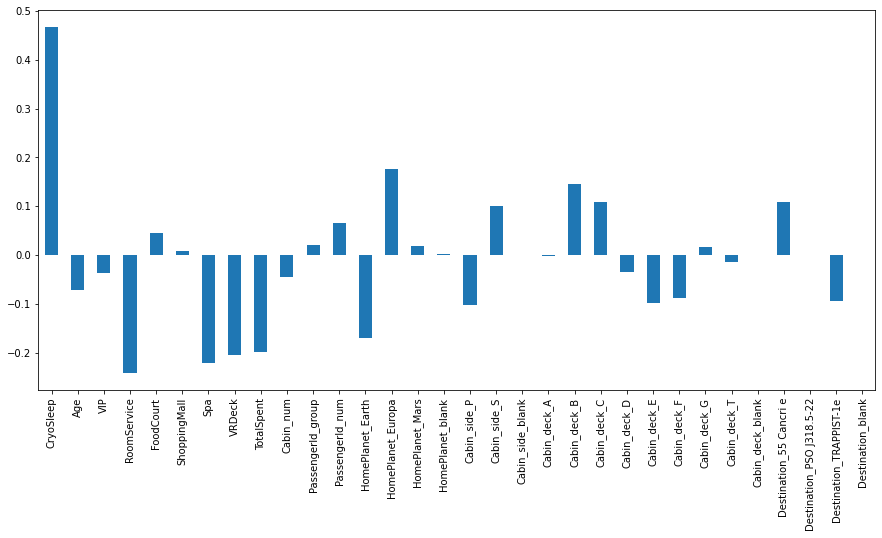

In [26]:
imputed_variables.corrwith(target).plot(kind='bar', figsize=(15, 7))

In [27]:
pickles = 'pickle'
if not os.path.exists(pickles):
    os.mkdir(pickles)

In [28]:
with open(f'{pickles}/regressors.pkl', 'wb') as pkl_file:
    dump(impute_regressors, pkl_file)

In [29]:
imputed_variables.to_csv('data/imputed_variables.csv')